## Neural Cellular Automata on PyTorch

This notebook is a "pytorch translation" of [this youtube video](https://www.youtube.com/watch?v=8EN_8p9Toyc) by Alexander Mordvintsev.

#### Important links:
* [Differentiable Self-organizing Systems thread on Distill](https://distill.pub/2020/selforg/)
* [Original Neural CA paper](https://distill.pub/2020/growing-ca/)
* [Another paper: Cellular automata as convolutional neural networks](https://arxiv.org/abs/1809.02942)

If you want to suggest any changes, feel free to make a PR :)

In [ ]:
!pip install torch-summary

In [1]:
import torch
import torch.nn as nn 
import numpy as np
import matplotlib.pyplot as plt 
import cv2 
import torch.nn.functional as F
import torch.optim as optim
from tqdm.notebook import tqdm
from IPython.display import Image, HTML, clear_output
from torchsummary import summary


In [2]:
# !wget -O flower.png https://raw.githubusercontent.com/googlefonts/noto-emoji/master/png/128/emoji_u1f33a.png
# !wget -O lizard.png https://emojipedia-us.s3.dualstack.us-west-1.amazonaws.com/thumbs/160/google/274/lizard_1f98e.png

## A brief intro

A cellular automaton is a collection of cells on a grid of specified shape that evolves through a number of discrete time steps according to a set of rules based on the states of neighboring cells. The rules are then applied iteratively for as many time steps as desired.

Now let's ask the following question:

**What if we could use a neural network to map a certain set of rules  that would help us generate a very specific arrangement of "cells" ?**

This is exactly what our objective is in this notebook.



## Let us start out by loading a target image

Do note that our image is a PNG file, this means that the image contains 4 channels: `[R,G,B,A]`

The image is intentionally small for fast and stable results. 

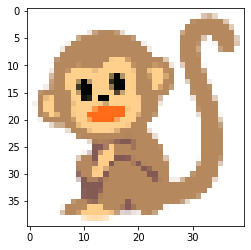

In [3]:
#@title {vertical-output: true}
width = 40
height = 40
filename = 'images/monkey.png'
device = 'cuda'
im = (cv2.cvtColor(cv2.resize(cv2.imread(filename, cv2.IMREAD_UNCHANGED), (width,height)), cv2.COLOR_BGRA2RGBA)/255.0).astype(np.float32)
plt.imshow(im)
plt.show()

### Viewing the alpha channel of the image

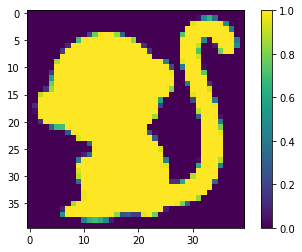

In [4]:
plt.imshow(im[:,:,3])  ## last channel 
plt.colorbar()

## Preparing a seed 

I'll break it down line by line:

* The seed will contain `16` channels, of which the first 4 would be the `[R,G,B,A]` channels, and the rest would be used by the NN to store some underlying information through the cellular automata steps.

* The seed would be a 4D array of dimensions `[1, width, height, 16]` with  

* We set the "center" value of the last 13 channels to 1

The white background is because the "alpha" channel value for all those pixel positions is zero. The black dot is there because the center value of the alpha channel is 1 (thus exposing the zeros from the `[R,G,B]` channels)

In [5]:
num_channels = 16
seed = np.zeros([1, width, height, num_channels], np.float32)
seed[:,width//2, height//2, 3:] = 1.0

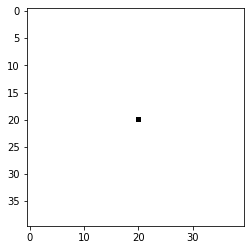

In [6]:
plt.imshow(seed[0,:,:,:4])
plt.show()

## Initializing the model

I'll break it down into 4 sections:
* Layers
* Special initialization conditions 
* Forward function
* Gradient normalization

### Layers

There are 2 layers:

**Layer 1**:  Simple conv layer, it's output size (per channel) is the same as the input size `(40,40)`. This is because the combination of `kernel_size` and `padding` is such that it's equivalent to "same" padding. The condition for same padding is:

```
padding = (kernel_size -1)/2 
## odd kernel size
```

**Layer 2**: Here we map the input back to the input shape: `[1, 16 , 40, 40]`. Note that the kernel size is 1 for "per cell" updates

### Special initialization conditions 

1. All the biases are set to zero
2. Weights of last layer are set to zero

This is because we want the initial condition of the model to be equivalent to an "identity function" that does nothing to the input image.
    
        
### Forward function:

The forward function is slightly reminiscent of residual nets. Instead of directly returning an output, it adds the result into the input tensor and returns the updated tensor. 

### Gradient normalization

This is done in order to make sure our gradient stay on a constant value, thus leading to more stable training.

In [7]:
class ca_model(nn.Module):
    def __init__(self, checkpoint = None):
        super(ca_model, self).__init__()

        self.model = nn.Sequential(
            
            # layer 1
            nn.Conv2d(16, 128, kernel_size = 3,padding =1,  bias = True), 
            
            # relu activation: y = x if x >=0 else 0
            nn.ReLU(),
            
            # layer 2
            nn.Conv2d(128, 16, kernel_size =  1, bias = True),
        )

        '''
        initial condition for "do nothing" behaviour:
            * all biases should be zero
            * the weights of the last layer should be zero
        '''
        self.model[0].bias.data.fill_(0)
        self.model[2].weight.data.fill_(0)
        self.model[2].bias.data.fill_(0)

        
    def forward(self, x):
        
        out = x + self.model(x)  ## reminds me of residual nets 
        return out
    

    def normalize_grads(self):
        
        for p in self.parameters():
            '''
            gradient normalization for constant step size and to avoid spikes 
            '''
            p.grad.data = p.grad.data/(p.grad.data.norm()+1e-9)

In [8]:
model = ca_model().to(device)
summary(model, (16,width,height))

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 16, 40, 40]          --
|    └─Conv2d: 2-1                       [-1, 128, 40, 40]         18,560
|    └─ReLU: 2-2                         [-1, 128, 40, 40]         --
|    └─Conv2d: 2-3                       [-1, 16, 40, 40]          2,064
Total params: 20,624
Trainable params: 20,624
Non-trainable params: 0
Total mult-adds (M): 32.79
Input size (MB): 0.10
Forward/backward pass size (MB): 1.76
Params size (MB): 0.08
Estimated Total Size (MB): 1.93


Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 16, 40, 40]          --
|    └─Conv2d: 2-1                       [-1, 128, 40, 40]         18,560
|    └─ReLU: 2-2                         [-1, 128, 40, 40]         --
|    └─Conv2d: 2-3                       [-1, 16, 40, 40]          2,064
Total params: 20,624
Trainable params: 20,624
Non-trainable params: 0
Total mult-adds (M): 32.79
Input size (MB): 0.10
Forward/backward pass size (MB): 1.76
Params size (MB): 0.08
Estimated Total Size (MB): 1.93

## Verifying the model's "do nothing behaviour"

We pass the input image through the model 100 times, and verify that it's still the same as the original input image

In [8]:
x = torch.tensor(seed).permute(0,-1,1,2).to(device)

for i in range(100):
    x = model(x)

out = x[0].permute(-1, -2,0).cpu().detach().numpy()[:,:,:4]
plt.imshow(out)
plt.show()


NameError: name 'model' is not defined

### Training boilerplate

* `train_step`: makes n forward passes through the model and calculates the loss w.r.t the target image
* `to_rgb`: converts 4 channel images to RGB

Given a starting point (`seed`), the model will learn to reproduce the target image (`target`) within n iterations `iters`

In [ ]:
def train_step(model, target, loss_func, iters, seed):
    x = seed 
    for i in range(iters):
        x =  model(x)
    loss = loss_func(x[:,:4, :,:], target)
    return loss, x


def to_rgb(img):
    rgb, a = img[:,:,:3], img[:,:,3:4]
    return 1.0-a+rgb

## Preparing for training 

Try to run this on an Nvidia GPU for faster results

In [10]:
model = ca_model().to(device)
optimizer = optim.Adam(model.parameters(), lr = 1e-3)

seed_tensor = torch.tensor(seed).permute(0,-1,1,2).to(device)
target = torch.tensor(im.transpose(-1,0,1)).unsqueeze(0).to(device)

losses = []
samples = []

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


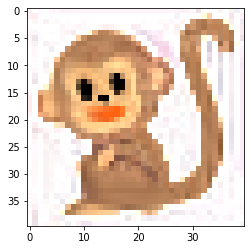

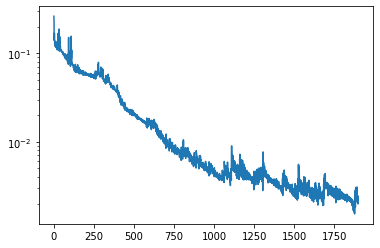

In [11]:
epochs  = 1900
for i in range(epochs):


    loss, out = train_step(
        model = model, 
        target = target, 
        loss_func = F.mse_loss, 
        iters = 50,
        seed = seed_tensor
        )
    
    ## calculate gradients
    loss.backward()

    ## normalize them
    model.normalize_grads()
    
    ## update weights and biases 
    optimizer.step()
    
    ## prevent accumulation of gradients
    optimizer.zero_grad()

    losses.append(loss.item())


    if i % 100 ==0 or i  == epochs-1:
        clear_output()
        samples.append(to_rgb(out[0].permute(-2, -1,0).cpu().detach().numpy()))
        plt.imshow(to_rgb(out[0].permute(-2, -1,0).cpu().detach().numpy()))
        plt.show()

        plt.plot(losses)
        # plt.plot(grads)
        plt.yscale('log')
        plt.show()

## Viewing our results 



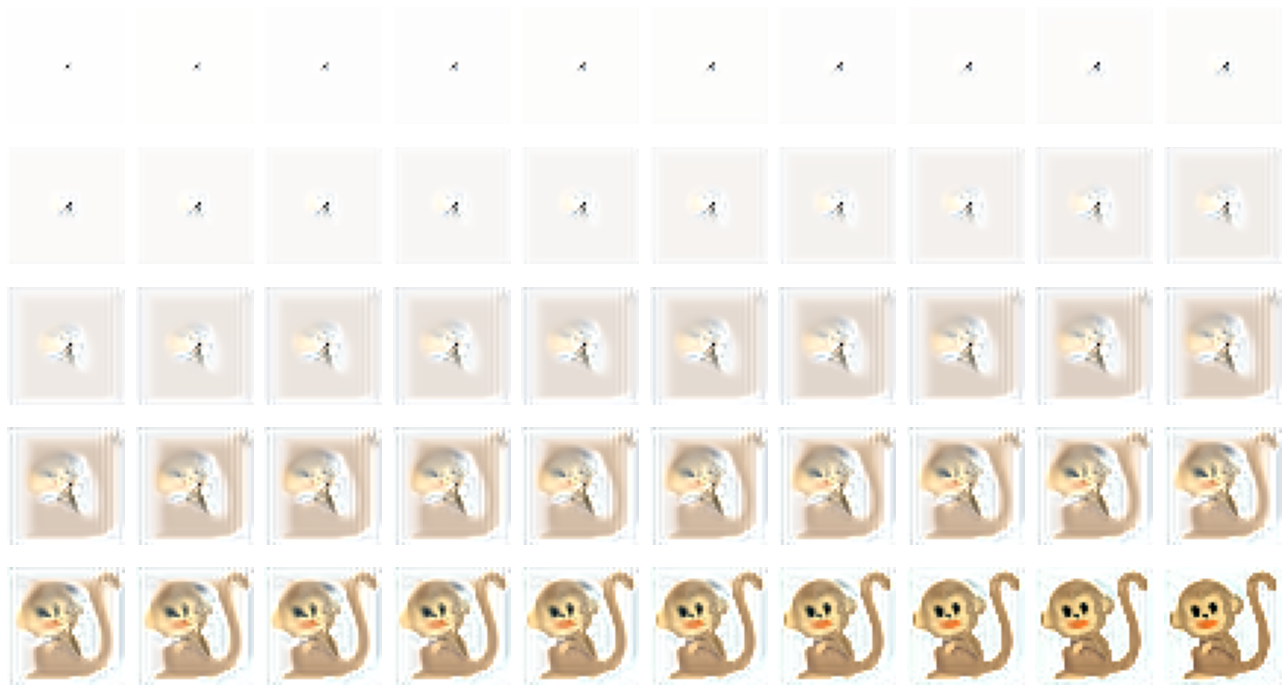

In [12]:
x = torch.tensor(seed).permute(0,-1,1,2).to(device)

outs = []
with torch.no_grad():

    for i in range(50):
        x = model(x)
        out = np.clip(to_rgb(x[0].permute(-2, -1,0).cpu().detach().numpy()), 0,1)
        outs.append(out)

fig, ax = plt.subplots(nrows=5, ncols=10, figsize = (18,10))

for i in range(len(outs)):
    ax.flat[i].imshow(outs[i])
    ax.flat[i].axis("off")
    
fig.tight_layout()

## The model works pretty well, but there are some issues

When we run inference on a larger image, the model tends to create bad outputs. The reason is that the model overfitted w.r.t the position of the corners in the image. 

Also, you might be able to see above that the model starts by filling the background with a shade of brown, and then slowly converges into the target. 

This behaviour is not what we intend to have, what we want is a system where only those cells can "evolve" which have adjacent "alive" cells.

In [19]:
num_channels = 16
new_width, new_height = 50,50
new_seed = np.zeros([1, new_width, new_height, num_channels], np.float32)
new_seed[:,new_width//2, new_height//2, 3:] = 1.0

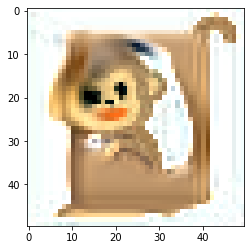

In [20]:
x = torch.tensor(new_seed).permute(0,-1,1,2).to(device)

with torch.no_grad():

    for i in range(50):
        x = model(x)

out = np.clip(to_rgb(x[0].permute(-2, -1,0).cpu().detach().numpy()), 0,1)
plt.imshow(out)

## Fixing the above issues

1. The "background filling" nature of the model can be reduced by diluting the update steps by multiplying it with a mask of 1's and 0's. This slows down the training, but also helps get more stable growth.

2. In order to fully address the problem, we have to introduce another loss function to the model, which penalizes the model whenever it deviates too far from the previous step's output. 

## Bonus: writing outputs into videos

In [86]:
import os

os.environ['FFMPEG_BINARY'] = 'ffmpeg'
import moviepy.editor as mvp
from moviepy.video.io.ffmpeg_writer import FFMPEG_VideoWriter

class VideoWriter:
    def __init__(self, filename='_autoplay.mp4', fps=15.0, **kw):
        self.writer = None
        self.params = dict(filename=filename, fps=fps, **kw)

    def add(self, img):
        img = np.asarray(img)
        if self.writer is None:
            h, w = img.shape[:2]
            self.writer = FFMPEG_VideoWriter(size=(w, h), **self.params)
        if img.dtype in [np.float32, np.float64]:
            img = np.uint8(img.clip(0, 1)*255)
        if len(img.shape) == 2:
            img = np.repeat(img[..., None], 3, -1)
        self.writer.write_frame(img)

    def close(self):
        if self.writer:
            self.writer.close()

    def __enter__(self):
        return self

    def __exit__(self, *kw):
        self.close()

    def show(self, **kw):
        self.close()
        fn = self.params['filename']
        display(mvp.ipython_display(fn, **kw))

In [ ]:
x = torch.tensor(seed).permute(0,-1,1,2).to(device)

v = VideoWriter(filename= "monkey.mp4")
outs = []
with torch.no_grad():

    for i in range(50):
        x = model(x)
        v.add(to_rgb(x[0].permute(-2, -1,0).cpu().detach().numpy()))

for j in range(10):
    v.add(to_rgb(x[0].permute(-2, -1,0).cpu().detach().numpy()))
    
v.close()
v.show()